# Paso 1: Limpiamos el entorno
Primero, eliminaremos todas las carpetas, archivos y datos previos. Ejecuta los siguientes comandos:

In [1]:
# Paso 1: Limpiamos solo la carpeta 'data_kaggle'

# Verificamos si la carpeta 'data_kaggle' existe y eliminarla
!rm -rf ./data_kaggle

# Listamos el contenido del entorno para verificar que la carpeta fue eliminada
!ls -la  # Debería mostrar solo las carpetas restantes, como .config



total 16
drwxr-xr-x 1 root root 4096 Oct 14 13:23 .
drwxr-xr-x 1 root root 4096 Oct 17 15:37 ..
drwxr-xr-x 4 root root 4096 Oct 14 13:22 .config
drwxr-xr-x 1 root root 4096 Oct 14 13:23 sample_data


# Paso 2: Creamos la estructura inicial una carpeta de nombre data_kaggle
Vamos a crear una carpeta llamada data_kaggle donde almacenaremos todos los archivos necesarios.
       

In [2]:
# Paso 2: Creamos la estructura inicial

# Creamos la carpeta data_kaggle
!mkdir data_kaggle


# Paso 3: Subimos  el archivo kaggle.json (token obtenido de la cuenta kaggle)

In [3]:
# Paso 3: Subimos el token kaggle.json al entorno de colab

from google.colab import files
files.upload()  # Subir kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alexandercd","key":"a898d94a9f8ebb29f7e53725b3390b2c"}'}

# 3.1 Movemos el archivo kaggle.json a la ubicación correcta es decir dentro de la carpeta data_kaggle para que Kaggle lo use (va como oculto):

In [4]:
# 3.1 Movemos el archivo kaggle.json a la ubicación correcta para que Kaggle lo use:

!mkdir -p ~/.kaggle  # Crea el directorio .kaggle si no existe
!mv kaggle.json ~/.kaggle/  # Mueve el archivo kaggle.json al directorio .kaggle
!chmod 600 ~/.kaggle/kaggle.json  # Ajusta los permisos para proteger el archivo



# Paso 4: Descargamos procedemos a descomprimir el dataset en la carpeta  data_kaggle

In [5]:
# Paso 4: Descargamos y procedemos a descomprimir el dataset en la carpeta data_kaggle

# Descargamos el dataset desde Kaggle
!kaggle datasets download -d rm1000/lung-cancer-histopathological-images

# Movemos el archivo descargado a la carpeta data_kaggle
!mv lung-cancer-histopathological-images.zip ./data_kaggle/

# Descomprimimos el contenido dentro de data_kaggle
!unzip ./data_kaggle/lung-cancer-histopathological-images.zip -d ./data_kaggle/



Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: ./data_kaggle/squamous_cell_carcinoma/0000.jpg  
  inflating: ./data_kaggle/squamous_cell_carcinoma/0001.jpg  
  inflating: ./data_kaggle/squamous_cell_carcinoma/0002.jpg  
  inflating: ./data_kaggle/squamous_cell_carcinoma/0003.jpg  
  inflating: ./data_kaggle/squamous_cell_carcinoma/0004.jpg  
  inflating: ./data_kaggle/squamous_cell_carcinoma/0005.jpg  
  inflating: ./data_kaggle/squamous_cell_carcinoma/0006.jpg  
  inflating: ./data_kaggle/squamous_cell_carcinoma/0007.jpg  
  inflating: ./data_kaggle/squamous_cell_carcinoma/0008.jpg  
  inflating: ./data_kaggle/squamous_cell_carcinoma/0009.jpg  
  inflating: ./data_kaggle/squamous_cell_carcinoma/0010.jpg  
  inflating: ./data_kaggle/squamous_cell_carcinoma/0011.jpg  
  inflating: ./data_kaggle/squamous_cell_carcinoma/0012.jpg  
  inflating: ./data_kaggle/squamous_cell_carcinoma/0013.jpg  
  inflating: ./data_kaggle/squamous_cell_carcinoma/0014.jpg  
  inflati

# Paso 5: Verificamos la estructura del dataset que existan las carpetas con los nombres de las 3 clases

In [6]:
# Paso 5: Después de la descompresión, vamos a verificar que las carpetas de las clases estén en data_kaggle.

# Listamos los contenidos de la carpeta data_kaggle
!ls ./data_kaggle

adenocarcinoma	benign	lung-cancer-histopathological-images.zip  squamous_cell_carcinoma


# Paso 6.1 creamos tres grupos (entrenamiento, prueba y validacion)

In [7]:
# 6.1 creanmos tres grupos (entrenamiento, prueba y validacion)
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from collections import Counter

# Definir las transformaciones para el preprocesamiento
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar la imagen
    transforms.ToTensor(),          # Convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizar
])

# Cargamos el dataset desde 'data_kaggle'
dataset = datasets.ImageFolder(root='./data_kaggle', transform=preprocess)

# Verificamos la distribución original de las clases
labels = [label for _, label in dataset.imgs]
print(f"Distribución Original: {Counter(labels)}")

# Separaramos 09 imágenes para validación (3-4 imágenes por clase)
val_size_per_class = 3  # 3 imágenes por clase, con un poco de ajuste para cubrir las 3 clases
val_indices = []

class_counts = Counter(labels)
for class_label in class_counts:
    class_indices = [i for i, label in enumerate(labels) if label == class_label]
    val_indices.extend(class_indices[:val_size_per_class])

# Creamos el dataset de validación con las 10 imágenes seleccionadas
val_dataset = torch.utils.data.Subset(dataset, val_indices)

# Filtramos las imágenes restantes para entrenamiento y prueba
remaining_indices = list(set(range(len(dataset))) - set(val_indices))
remaining_dataset = torch.utils.data.Subset(dataset, remaining_indices)

# Dividimos el dataset restante en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(remaining_dataset))
test_size = len(remaining_dataset) - train_size
train_dataset, test_dataset = random_split(remaining_dataset, [train_size, test_size])

# Verificamos la distribución en los 3 conjuntos
train_labels = [dataset.targets[i] for i in train_dataset.indices]
test_labels = [dataset.targets[i] for i in test_dataset.indices]
val_labels = [dataset.targets[i] for i in val_dataset.indices]

print(f"Distribución en Entrenamiento: {Counter(train_labels)}")
print(f"Distribución en Prueba: {Counter(test_labels)}")
print(f"Distribución en Validación: {Counter(val_labels)}")

# Creamos los DataLoaders para cada conjunto
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Entrenamiento
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)   # Prueba
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)     # Validación

# Verificamos la carga de los datos
print(f"Total de imágenes: {len(dataset)}")
print(f"Imágenes de entrenamiento: {len(train_dataset)}")
print(f"Imágenes de prueba: {len(test_dataset)}")
print(f"Imágenes de validación: {len(val_dataset)}")


Distribución Original: Counter({0: 5000, 1: 5000, 2: 5000})
Distribución en Entrenamiento: Counter({0: 4007, 1: 4002, 2: 3983})
Distribución en Prueba: Counter({2: 1008, 1: 998, 0: 993})
Distribución en Validación: Counter({0: 3, 1: 3, 2: 3})
Total de imágenes: 15000
Imágenes de entrenamiento: 11992
Imágenes de prueba: 2999
Imágenes de validación: 9


# 6.2 Recorrido de los 3 grupos creados (vista previa de 10 imagenes por grupo)

In [8]:
# 6.2 Recorrido de los 3 grupos creados
import matplotlib.pyplot as plt
import torchvision

# Función para mostrar un lote de imágenes con sus etiquetas
def show_images_from_loader(loader, class_names, group_name):
    # Obtener un solo lote de imágenes
    images, labels = next(iter(loader))

    # Creamos una cuadrícula de 2x5 para mostrar 10 imágenes
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f'Imágenes del Grupo: {group_name}', fontsize=16)

    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            # Desnormalizar la imagen para mostrarla correctamente
            img = images[i].permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            img = img.numpy().clip(0, 1)  # Asegurarse de que los valores estén en [0, 1]

            ax.imshow(img)
            ax.set_title(f'Clase: {class_names[labels[i].item()]}')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.show()

# Clases del dataset
class_names = ['Adenocarcinoma', 'Benigno', 'Carcinoma de células escamosas']

# Mostramos algunas imágenes de cada grupo
print("Visualizando grupo de Entrenamiento...")
show_images_from_loader(train_loader, class_names, "Entrenamiento")

print("Visualizando grupo de Prueba...")
show_images_from_loader(test_loader, class_names, "Prueba")

print("Visualizando grupo de Validación...")
show_images_from_loader(val_loader, class_names, "Validación")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Paso 7: Confirmación el paso 6 debio mostrar estos
# Al ejecutar el código anterior, deberías ver algo como:
#mathematica
#Copiar código
#Total de imágenes: 15000
#Imágenes de entrenamiento: 12000
#Imágenes de prueba: 3000

#Paso 7: Procedemos a cargar el Modelo GoogLeNet

In [ ]:
#Paso 7: Vamos a cargar el modelo GoogLeNet utilizando PyTorch. Como tenemos tres clases en nuestro dataset (adenocarcinoma, benign, squamous_cell_carcinoma), configuraremos el modelo para que trabaje con esas clases.

#Código: Definición del modelo

import torchvision.models as models

# Cargamos GoogLeNet sin pesos preentrenados
googlenet = models.googlenet(pretrained=False, num_classes=3)  # 3 clases en nuestro dataset

# Enviamos el modelo a la GPU si está disponible, de lo contrario usamos CPU de colab
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
googlenet = googlenet.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


#Paso 8: Definimos la Función de Pérdida y el Optimizador

In [ ]:
#Paso 8: Definimos la Función de Pérdida y el Optimizador, Vamos a utilizar CrossEntropyLoss como la función de pérdida (adecuada para clasificación) y Adam como el optimizador.

# Definimos la función de pérdida y el optimizador
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()  # Pérdida de entropía cruzada
optimizer = optim.Adam(googlenet.parameters(), lr=0.001)  # Optimizador Adam


#  Paso 9: Codigo de entrenamiento que guarda las perdidas y el acuraccy por cada epoca, cuyos valores utilizaremos en las curvas de ganancias y perdida mas adelante en el paso 12

In [ ]:
#Paso 9  # CODIGO DE ENTRENAMIENTO QUE GUARDA LAS PERDIDAS Y EL ACURACCY POR CADA EPOCA (EJECUTADO)

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()  # Cambiamos al modo de entrenamiento

    train_losses = []  # Almacenamos las pérdidas de entrenamiento por época
    val_accuracies = []  # Almacenamos las exactitudes por época

    for epoch in range(epochs):
        running_loss = 0.0  # Acumulador de la pérdida
        correct = 0  # Contador de predicciones correctas
        total = 0  # Total de ejemplos procesados

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Enviar a GPU/CPU

            optimizer.zero_grad()  # Reiniciamos los gradientes
            outputs = model(inputs)  # Forward pass

            # Si el modelo devuelve múltiples salidas, selecciona solo la principal
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, labels)  # Calculamos la pérdida

            # Backpropagation y optimización
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calcular las predicciones correctas
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Calculamos pérdida y exactitud para la época actual
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total

        train_losses.append(epoch_loss)
        val_accuracies.append(epoch_accuracy)

        print(f"Época {epoch + 1}/{epochs}, Pérdida: {epoch_loss:.4f}, Exactitud: {epoch_accuracy:.4f}")

    return train_losses, val_accuracies

# Entrenamos el modelo y obtenemos las pérdidas y exactitudes
train_losses, val_accuracies = train_model(googlenet, train_loader, criterion, optimizer, epochs=10)


Época 1/12, Pérdida: 0.0471, Exactitud: 0.9828
Época 2/12, Pérdida: 0.0428, Exactitud: 0.9852
Época 3/12, Pérdida: 0.0475, Exactitud: 0.9826
Época 4/12, Pérdida: 0.0326, Exactitud: 0.9888
Época 5/12, Pérdida: 0.0331, Exactitud: 0.9885
Época 6/12, Pérdida: 0.0237, Exactitud: 0.9919
Época 7/12, Pérdida: 0.0316, Exactitud: 0.9890
Época 8/12, Pérdida: 0.0162, Exactitud: 0.9933
Época 9/12, Pérdida: 0.0334, Exactitud: 0.9884
Época 10/12, Pérdida: 0.0217, Exactitud: 0.9921
Época 11/12, Pérdida: 0.0217, Exactitud: 0.9927
Época 12/12, Pérdida: 0.0173, Exactitud: 0.9930


# 9.1 Para no volver a gastar GPU, guardamos el modelo entrenado con extension .pth


In [ ]:
# Guardar el modelo entrenado
torch.save(googlenet.state_dict(), 'googlenet_model.pth')
print("Modelo guardado como googlenet_model.pth")


Modelo guardado como googlenet_model.pth


# Paso 10.1 Evaluacion de las Métricas del modelo por clase

In [16]:
# Paso 10.1: Evaluamos el Modelo con Métricas

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def evaluar_modelo(model, dataloader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()  # Cambiamos a modo evaluación
    all_preds = []  # Lista para almacenar predicciones
    all_labels = []  # Lista para almacenar etiquetas reales

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Obtenemos predicciones

            all_preds.extend(preds.cpu().numpy())  # Almacenamos predicciones
            all_labels.extend(labels.cpu().numpy())  # Almacenamos etiquetas reales

    # Calculo del accuracy general usando accuracy_score
    accuracy = accuracy_score(all_labels, all_preds)

    # Generaramos el reporte de clasificación en español
    nombres_clases = ['Adenocarcinoma', 'Benigno', 'Carcinoma de células escamosas']
    reporte = classification_report(all_labels, all_preds, target_names=nombres_clases, output_dict=True)

    # Imprimimos las métricas en español de forma ordenada
    print("\n**Métricas de Evaluación del Modelo**\n")
    for clase, metricas in reporte.items():
        if clase in nombres_clases:  # Solo mostramos las clases relevantes
            print(f"Clase: {clase}")
            print(f" - Precisión: {metricas['precision']:.2f}")
            print(f" - Exhaustividad (Recall): {metricas['recall']:.2f}")
            print(f" - Puntuación F1: {metricas['f1-score']:.2f}")
            print(f" - Soporte (número de muestras): {metricas['support']}\n")

    # Imprimimos el accuracy general
    print(f"Exactitud general del modelo (Accuracy): {accuracy:.2f}")

# Ejecutamos la evaluación
evaluar_modelo(googlenet, test_loader)




**Métricas de Evaluación del Modelo**

Clase: Adenocarcinoma
 - Precisión: 0.99
 - Exhaustividad (Recall): 1.00
 - Puntuación F1: 1.00
 - Soporte (número de muestras): 993.0

Clase: Benigno
 - Precisión: 1.00
 - Exhaustividad (Recall): 1.00
 - Puntuación F1: 1.00
 - Soporte (número de muestras): 997.0

Clase: Carcinoma de células escamosas
 - Precisión: 1.00
 - Exhaustividad (Recall): 1.00
 - Puntuación F1: 1.00
 - Soporte (número de muestras): 1009.0

Exactitud general del modelo (Accuracy): 1.00


# Paso 11: Mostramos la Matriz de Confusión

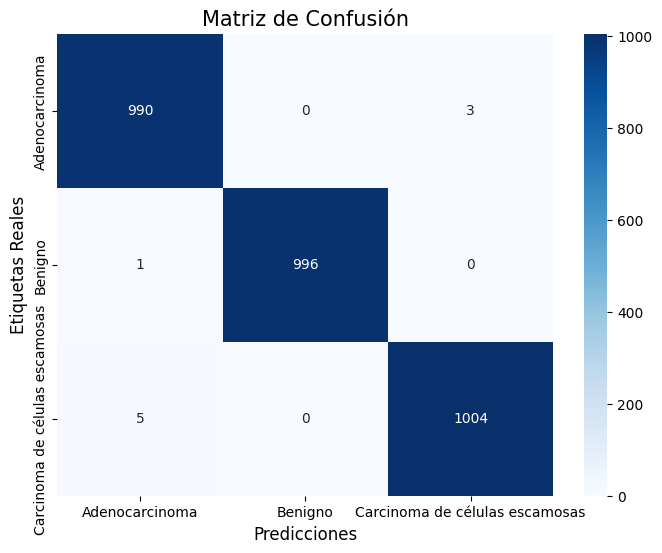

In [13]:
#Paso 11: Mostrar Matriz de Confusión en un Gráfico

#Código para la Matriz de Confusión
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def mostrar_matriz_confusion(model, dataloader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()  # Cambiamos a modo evaluación

    # Listas para almacenar las predicciones y las etiquetas reales
    all_preds = []
    all_labels = []

    # Realizamos las predicciones sobre el conjunto de prueba
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Obtenemos las predicciones

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generamos la matriz de confusión
    nombres_clases = ['Adenocarcinoma', 'Benigno', 'Carcinoma de células escamosas']
    matriz_conf = confusion_matrix(all_labels, all_preds)

    # Configuramos el gráfico con Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_conf, annot=True, cmap='Blues', fmt='d',
                xticklabels=nombres_clases, yticklabels=nombres_clases)

    # Añadimos etiquetas y título al gráfico
    plt.xlabel('Predicciones', fontsize=12)
    plt.ylabel('Etiquetas Reales', fontsize=12)
    plt.title('Matriz de Confusión', fontsize=15)
    plt.show()

# Ejecutamos la función para mostrar la matriz de confusión
mostrar_matriz_confusion(googlenet, test_loader)



# Paso 12:  Generación del Gráfico de Pérdida y Exactitud:

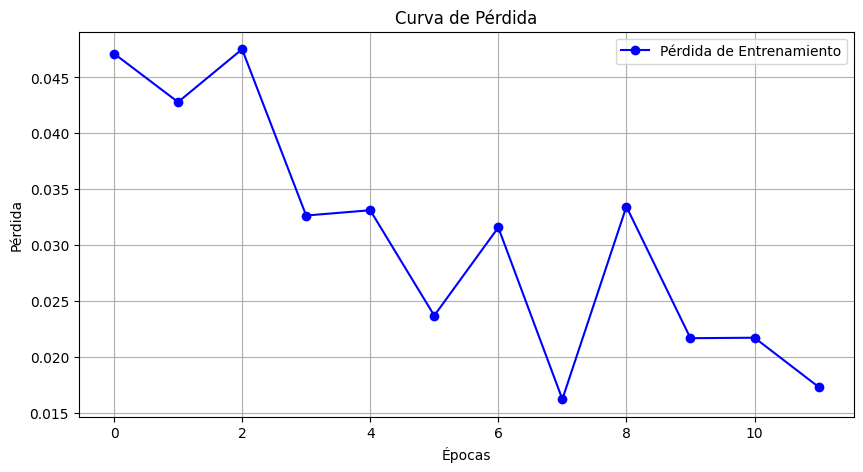

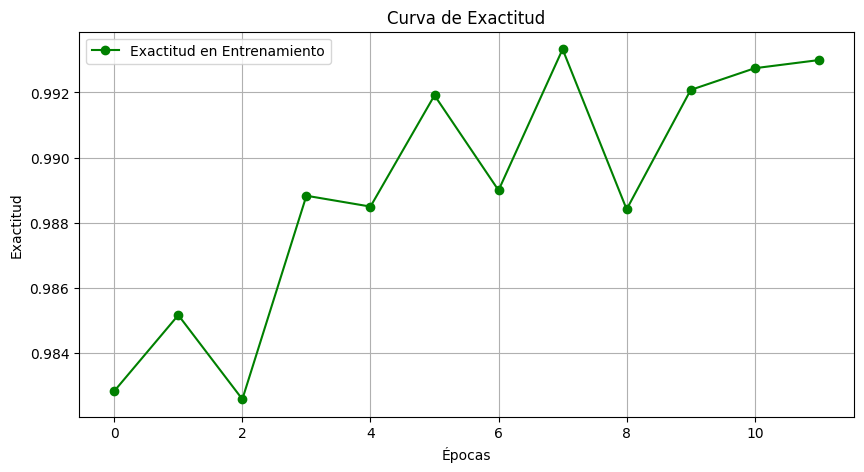

In [ ]:
#PASO 12 # Generación del Gráfico de Pérdida y Exactitud:
# habiendo obtenido las listas train_losses y val_accuracies completas, procedemos a graficarlas:
import matplotlib.pyplot as plt

# Gráfico de pérdida
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Pérdida de Entrenamiento', marker='o', color='blue')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curva de Pérdida')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de exactitud
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Exactitud en Entrenamiento', marker='o', color='green')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.title('Curva de Exactitud')
plt.legend()
plt.grid(True)
plt.show()


# PASO 13.1 Probando con una Imagen Individual desde una link publico en la web

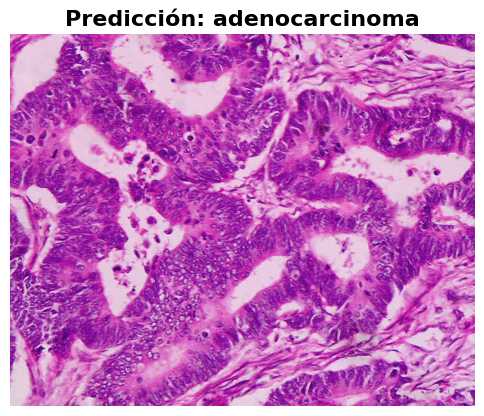

In [12]:
#PASO 13.1 Probar con una Imagen Individual desde una URL publica en internet

import requests
from PIL import Image, UnidentifiedImageError
from io import BytesIO
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Definimos dispositivo (CPU o GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# URL de la imagen que deseamos probar
url = 'https://upload.wikimedia.org/wikipedia/commons/f/f8/Adenocarcinoma_highly_differentiated_%28rectum%29_H%26E_magn_400x.jpg'

# Encabezados para imitar una solicitud desde un navegador
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
}

try:
    # Descargamos la imagen con los encabezados
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Verificamos si la solicitud fue exitosa

    # Verificamos el tipo de contenido
    if "image" not in response.headers["Content-Type"]:
        print("Error: El contenido descargado no es una imagen.")
    else:
        try:
            # Intentamos abrir la imagen
            img = Image.open(BytesIO(response.content)).convert("RGB")
        except UnidentifiedImageError:
            print("Error: No se pudo identificar el archivo como una imagen.")
            raise

        # Preprocesamos la imagen (igual que en el entrenamiento)
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),  # Redimensionamos la imagen
            transforms.ToTensor(),          # Convertimos a tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizar
        ])

        # Aplicamos las transformaciones
        img_tensor = preprocess(img).unsqueeze(0).to(device)  # Añadir batch y mover a GPU/CPU

        # Realizamos la predicción
        googlenet.eval()  # Aseguramos que el modelo está en modo de evaluación
        with torch.no_grad():
            outputs = googlenet(img_tensor)  # Forward pass
            _, pred = torch.max(outputs, 1)  # Obtenemos la clase predicha

        # Definimos las clases
        classes = ['adenocarcinoma', 'benigno', 'carcinoma de células escamosas']

        # Obtenemos la clase predicha
        predicted_class = classes[pred.item()]


        # Mostramos la imagen y la predicción
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Predicción: {predicted_class}", fontsize=16, fontweight='bold')
        plt.axis('off')  # Ocultamos los ejes
        plt.show()

except requests.exceptions.RequestException as e:
    print(f"Error al descargar la imagen: {e}")


# Paso 14: Código para Probar el Modelo con las Imágenes del Grupo de validación (9 imagenes)

In [19]:
# Paso 14 Código para Probar el Modelo con las Imágenes del Grupo de validación (9 imagenes)

import matplotlib.pyplot as plt
import torch

# Verificamos de que el modelo esté en modo de evaluación
googlenet.eval()

# Definimos las clases del modelo
classes = ['adenocarcinoma', 'benigno', 'carcinoma de células escamosas']

# Iteramos sobre las imágenes del conjunto de validación
with torch.no_grad():  # Desactivamos gradientes para pruebas
    for img, label in val_loader:  # Cargamos batch de validación
        img, label = img.to(device), label.to(device)  # Enviamos a GPU/CPU

        # Realizamos la predicción
        output = googlenet(img)
        _, pred = torch.max(output, 1)  # Obtenemos la clase predicha

        # Mostrarmos la imagen y su predicción
        for i in range(len(img)):  # Iteramos sobre cada imagen del batch
            # Desnormalizamos la imagen para mostrarla correctamente
            img_desnormalizada = (
                img[i].cpu() * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) +
                torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            ).clip(0, 1)  # Aseguramos que los valores estén en [0, 1]

            # Mostramos la imagen
            plt.imshow(img_desnormalizada.permute(1, 2, 0).numpy())  # Cambiamos dimensiones
            plt.title(f"Predicción: {classes[pred[i].item()]} | Etiqueta Real: {classes[label[i].item()]}")
            plt.axis('off')  # Ocultamos ejes
            plt.show()





Output hidden; open in https://colab.research.google.com to view.

# Cargar el modelo guardado para validación futura
Si apagamos el equipop o salimos de Colab y deseamos validar el modelo sin volver a entrenarlo ni gastar recursos de GPU, seguimos estos pasos :



In [9]:
# 1. Subimos el archivo del modelo .pth a Colab el mismo que fue generado en el paso 9.1
from google.colab import files
uploaded = files.upload()  # Subir googlenet_model.pth



Saving googlenet_model.pth to googlenet_model.pth


# EJECUTAR DESDE EL PASO 1 HASTA EL 6, LUEGO EJECUTAR ESTE CODIGO

In [10]:
# 2. Inicializamos y cargamos el modelo guardado:  (Equivalente al paso 7)
import torch
from torchvision.models import googlenet

# Inicializamos el modelo GoogLeNet sin pesos preentrenados
googlenet = googlenet(pretrained=False, num_classes=3)  # Asegúrate de que 'num_classes=3'

# Cargamos los pesos desde el archivo subido
model_path = list(uploaded.keys())[0]  # Obtenemos el nombre del archivo subido
googlenet.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Enviamos el modelo a GPU si está disponible, de lo contrario usar CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
googlenet.to(device)

# Ponemos el modelo en modo evaluación
googlenet.eval()
print("Modelo cargado y listo para usar.")



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Modelo cargado y listo para usar.


<ipython-input-10-288384cddcbf>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  googlenet.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


In [20]:
# Paso 3: Probamos el modelo con las imágenes del grupo de validación (Equivalente al paso 14)
import matplotlib.pyplot as plt
import torch

# Nos aseguramos de que el modelo esté en modo de evaluación
googlenet.eval()

# Definimos las clases del modelo
classes = ['adenocarcinoma', 'benigno', 'carcinoma de células escamosas']

# Iteramos sobre las imágenes del conjunto de validación
with torch.no_grad():  # Desactivamos gradientes para pruebas
    for img, label in val_loader:  # Cargamos batch de validación
        img, label = img.to(device), label.to(device)  # Enviamos a GPU/CPU

        # Realizamos la predicción
        output = googlenet(img)
        _, pred = torch.max(output, 1)  # Obtenemos la clase predicha

        # Mostramos la imagen y su predicción
        for i in range(len(img)):  # Iteramos sobre cada imagen del batch
            # Desnormalizamos la imagen para mostrarla correctamente
            img_desnormalizada = (
                img[i].cpu() * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) +
                torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            ).clip(0, 1)  # Aseguramos que los valores estén en [0, 1]

            # Mostramos la imagen
            plt.imshow(img_desnormalizada.permute(1, 2, 0).numpy())  # Cambiar dimensiones
            plt.title(f"Predicción: {classes[pred[i].item()]} | Etiqueta Real: {classes[label[i].item()]}")
            plt.axis('off')  # Ocultar ejes
            plt.show()



Output hidden; open in https://colab.research.google.com to view.